In [252]:
import ast
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re
from collections import Counter
import pandas as pd

In [225]:
pr = pd.read_csv('data/clean_tables/profiles.csv')
jbp = pd.read_csv('data/clean_tables/job_postings.csv')
jbp.dropna(subset=['skills'], inplace=True)

to_csv = False

In [103]:
jbp.shape

(10094, 12)

In [88]:
final_cols = ['id', 'position', 'education_degrees', 'experience_titles', 'total_years_relevant_experience']

In [131]:
def count_education(df):
    df['education_degrees'] = df['education_degrees'].apply(ast.literal_eval)
    result = {}

    for index, row in df.iterrows():

        position = row['position']
        education_list = row['education_degrees']

        if position not in result:
            result[position] = {}

        for education_item in education_list:
            if education_item not in result[position]:
                result[position][education_item] = 1
            else:
                result[position][education_item] += 1

    result_df = pd.DataFrame(result).transpose()
    result_df.fillna(0, inplace=True)
    return result_df


def get_years_of_experience(df):
    result = {}
    for index, row in df.iterrows():
        position = row['position']
        total_years = row['total_years_relevant_experience']

        if position not in result:
            result[position] = []
        result[position].append(total_years)
    return result


def get_original_titles(df):
    result = {}
    for index, row in df.iterrows():
        position = row['position']
        original_title = row['position_original']

        if position not in result:
            result[position] = []
        result[position].append(original_title)
    return result


def count_skills(df):
    df['skills'] = df['skills'].apply(ast.literal_eval)
    result = {}

    for index, row in df.iterrows():
        position = row['position']
        skills_list = row['skills']
        if position not in result:
            result[position] = {}

        for skill_item in skills_list:
            if skill_item not in result[position]:
                result[position][skill_item] = 1
            else:
                result[position][skill_item] += 1

    result_df = pd.DataFrame(result).transpose()
    result_df.fillna(0, inplace=True)
    return result_df

In [132]:
experience_dict = get_years_of_experience(pr)
original_titles_dict = get_original_titles(pr)
ed_dict_raw = count_education(pr).transpose().to_dict()
ed_dict = {k: {v: c for v, c in ed_dict_raw[k].items() if c > 0} for k in ed_dict_raw.keys()}
skills_dict_raw = count_skills(jbp).transpose().to_dict()
skills_dict = {k: {v: c for v, c in skills_dict_raw[k].items() if c > 5} for k in skills_dict_raw.keys()}
for k, v in skills_dict.items():
    if len(skills_dict[k].keys()) == 0:
        skills_dict[k] = {v: c for v, c in skills_dict_raw[k].items() if c >= 1}

In [133]:
joined_df = pd.DataFrame(ed_dict.keys()).rename({0: "position"}, axis=1)
joined_df['skills'] = joined_df['position'].apply(lambda x: skills_dict[x] if x in skills_dict.keys() else {})
joined_df['education'] = joined_df['position'].apply(lambda x: ed_dict[x] if x in ed_dict.keys() else {})
joined_df['original_titles'] = joined_df['position'].apply(
    lambda x: original_titles_dict[x] if x in original_titles_dict.keys() else {})
joined_df['years_of_experience'] = joined_df['position'].apply(
    lambda x: experience_dict[x] if x in experience_dict.keys() else {})
joined_df['position_count'] = joined_df['years_of_experience'].apply(lambda x: len(x))
if to_csv:
    joined_df.to_csv('data/clean_tables/final_EM.csv', index='position')

,position,skills,education,original_titles,years_of_experience
0,Facilitator,"{'Teamwork': 9.0, 'Communication': 15.0}","{'MA': 85.0, 'BA': 216.0, 'MS': 60.0, 'BS': 14...","[IEP Facilitator, Instructional Designer & Fac...","[9.0, 4.42, 4.08, 23.0, 9.84, 11.01, 32.5, 56...."
1,Project Manager (PM),"{'Customer Service': 6.0, 'Analytical Skills':...","{'MA': 106.0, 'BA': 647.0, 'MS': 327.0, 'BS': ...","[Project Manager, Physician | Prior Clinical T...","[8.75, 7.91, 6.0, 18.07, 6.66, 1.08, 16.17, 0...."
2,Executive Assistant,"{'Customer Service': 7.0, 'Communication skill...","{'MA': 24.0, 'BA': 289.0, 'MS': 21.0, 'BS': 19...","[Executive Assistant, Executive Assistant to t...","[6.91, 9.0, 6.34, 6.26, 2.08, 32.99, 16.0, 23...."
3,Advisor,"{'Sales': 138.0, 'Customer Service': 67.0, 'Fi...","{'MA': 149.0, 'BA': 758.0, 'MS': 186.0, 'BS': ...","[OD Advisor at Vaya Health, Membership Advisor...","[0.0, 8.35, 0.0, 2.84, 9.09, 6.74, 3.82, 8.5, ..."
4,Math Teacher,"{'Analytical Skills': 1.0, 'Communication skil...","{'MA': 27.0, 'BA': 51.0, 'MS': 30.0, 'BS': 102...",[Upper School Science & Math Teacher at Carita...,"[7.17, 4.42, 13.17, 7.0, 0.0, 2.75, 0.0, 9.67,..."
...,...,...,...,...,...
224,Chef Manager,"{'Teamwork': 6.0, 'Communication': 10.0, 'Lead...","{'BA': 8.0, 'BS': 10.0, 'Certificate': 10.0, '...","[General Manager and private chef, General Man...","[10.83, 11.16, 9.08, 20.83, 26.1, 2.41, 29.25,..."
225,Registered Nurse Clinical Information Systems ...,"{'Communication skills': 1.0, 'Problemsolving'...","{'MA': 1.0, 'BA': 2.0, 'MS': 3.0, 'BS': 5.0, '...","[Clinical Nurse, 3M Systems Coordinator, Clini...","[2.17, 6.0, 5.09, 5.84, 21.92, 3.58, 9.34, 7.4..."
226,Health Care Manager,"{'Teamwork': 4.0, 'Problemsolving': 1.0, 'Comm...","{'MA': 1.0, 'BA': 2.0, 'MS': 1.0, 'BS': 8.0, '...","[Care Manager, Health Care, Health Care, Care ...","[10.1, 9.33, 9.92, 0.0, 1.83, 6.67, 4.25, 11.0..."
227,Full Stack Software Engineer,{},"{'BA': 1.0, 'MS': 2.0, 'BS': 5.0, 'Certificate...","[Full Stack Engineer, Full Stack Engineer, Ful...","[2.83, 5.91, 8.5, 8.75, 3.25, 4.17, 21.16, 13...."


In [145]:
unavailable_skills_positions = joined_df[joined_df['skills'] == {}].position.tolist()
print(f"Skills for positions: \n{unavailable_skills_positions}\nAre not available.")

Skills for positions: 
['Health Director', 'Medical Director', 'Regional Director', 'Clinical Director', 'Academic Advisor', 'Tax Administrative Assistant', 'Executive Director', 'City Engineer', 'Finance Director', 'Bioinformatics Scientist', 'Client Advisor', 'Statistician', 'Full Stack Software Engineer']
Are not available.


In [260]:
colors = ['#164863', '#427D9D', '#9BBEC8', '#DDF2FD', '#F2EBE9', '#6B818C']


def plot_position_data2(df, position_title):
    def generate_summary_text(skills_counts, education_counts):
        top_skills_text = "\n".join([
                                        f"- {skill}, with {(count / len(skills_counts.items())) * 100} % of the {position_title}s skills we've collected"
                                        for skill, count in skills_counts.items()][:5])
        top_education_text = "\n".join(
            [f"- {education}: {(count / len(education_counts.items())) * 100} % of the education mentions" for
             education, count in education_counts.items()][:5])

        summary_text = f"For the position of {position_title}, the top skills are:\n{top_skills_text}\n\n"
        summary_text += f"Also, the top education levels are:\n{top_education_text}"

        return summary_text

    def create_word_cloud(bag_of_words):
        custom_stopwords = set(STOPWORDS)
        custom_stopwords.update({"job", "title", "position", "at", "end", "of", "skills", "0", "1"})
        wordcloud = WordCloud(width=800, height=400, background_color='white',
                              stopwords={"job", "title", "position", "at", "end", "of", "skills", "0", "1"},
                              colormap='Blues',collocation_threshold=50).generate_from_frequencies(bag_of_words)
        plt.figure(figsize=(10, 8))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f"Bag of Words - {position_title} Required Skills")
        plt.axis('off')
        plt.show()

    def create_bag_of_words(df):
        all_skills = ' '.join(df['skills'].values.astype(str))
        words = re.findall(r'\b[a-zA-Z]+\b', all_skills.lower())
        word_counts = Counter(words)
        return word_counts

    position_data = df[df['position'] == position_title]

    if 'education' in position_data.columns:
        education_counts = position_data['education'].iloc[0]
        sorted_education_counts = dict(sorted(education_counts.items(), key=lambda x: x[1], reverse=True))
        top_5_education = dict(list(sorted_education_counts.items())[:5])
        all_other_count = sum(sorted_education_counts.values()) - sum(top_5_education.values())
        combined_education_counts = {**top_5_education, 'All Other': all_other_count}

        plt.figure(figsize=(8, 6))
        plt.pie(combined_education_counts.values(), labels=combined_education_counts.keys(), autopct='%1.1f%%',
                startangle=140, colors=colors)
        plt.title(f"Educational Levels for {position_title}")
        plt.axis('equal')
        plt.show()

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    if 'skills' in position_data.columns:
        skills_counts = position_data['skills'].iloc[0]
        total_skills = sum(skills_counts.values())
        skills_percentages = {skill: (count / total_skills) * 100 for skill, count in
                              position_data['skills'].iloc[0].items()}
        skills_df = pd.DataFrame(list(skills_percentages.items()), columns=['skill', 'p'])
        skills_df = skills_df.sort_values(by='p', ascending=True)

        num_skills_to_display = min(15, len(skills_df))
        skills_df = skills_df.iloc[-num_skills_to_display:]

        axes[0].barh(skills_df['skill'], skills_df['p'], color='#A3816A', edgecolor='#0A065D',alpha=0.8)
        axes[0].set_xlabel('Percentage (%)')
        axes[0].set_ylabel('Skill')
        axes[0].set_title(f'Top Skills for {position_title} (%)')

        summary_text = generate_summary_text(skills_counts, education_counts)
        axes[1].axis('off')
        axes[1].text(0.5, 0.5, summary_text, fontsize=12, ha='center', va='center', fontfamily='Arial',
                     fontweight='bold')
        plt.show()

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    if 'years_of_experience' in position_data.columns:
        years_of_experience = position_data['years_of_experience']

        axes[0].hist(years_of_experience, bins=15, color='#A3816A', edgecolor='#0A065D')
        axes[0].set_title(f"Years of Experience for {position_title}")
        axes[0].set_xlabel("Years of Experience")
        axes[0].set_ylabel("Frequency")

        axes[1].boxplot(years_of_experience, vert=False)
        axes[1].set_title(f"Years of Experience for {position_title}")
        axes[1].set_xlabel("Years of Experience")

        plt.tight_layout()
        plt.show()

    bag_of_words = create_bag_of_words(position_data)
    create_word_cloud(bag_of_words)


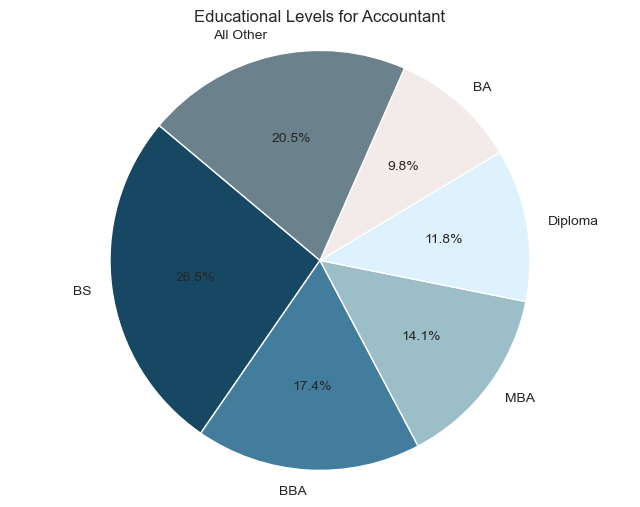

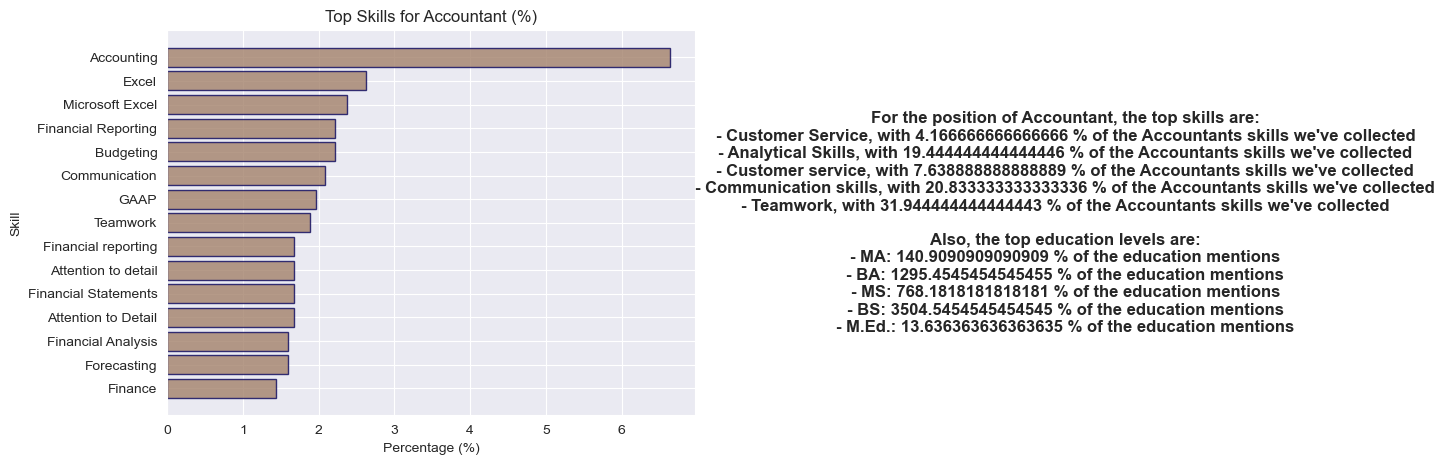

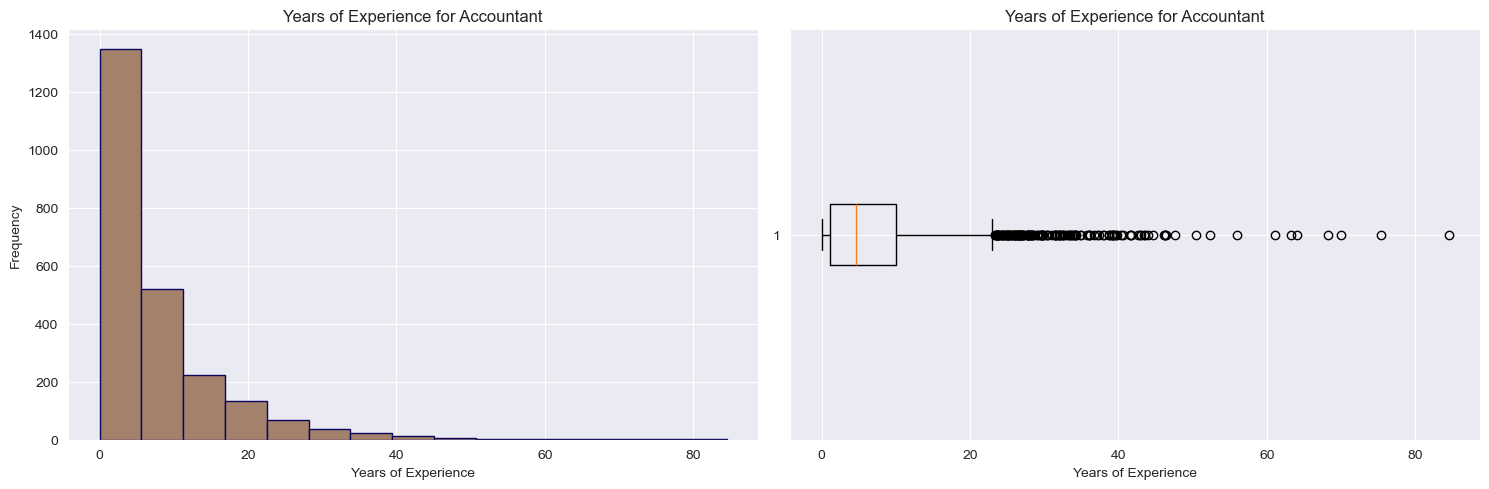

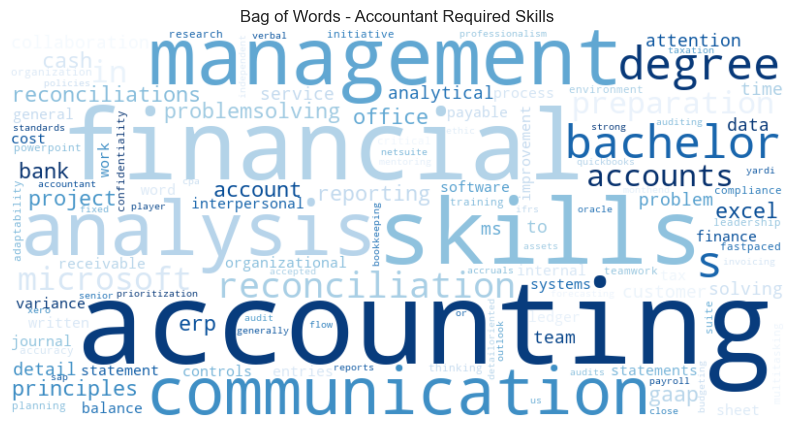

In [261]:
user_input = 'Accountant'
pdf = joined_df[joined_df['position'] == user_input]
plot_position_data2(joined_df, user_input)